In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib

while pathlib.Path(".").absolute().name != "aerial-disentangled-representations":
    os.chdir("..")

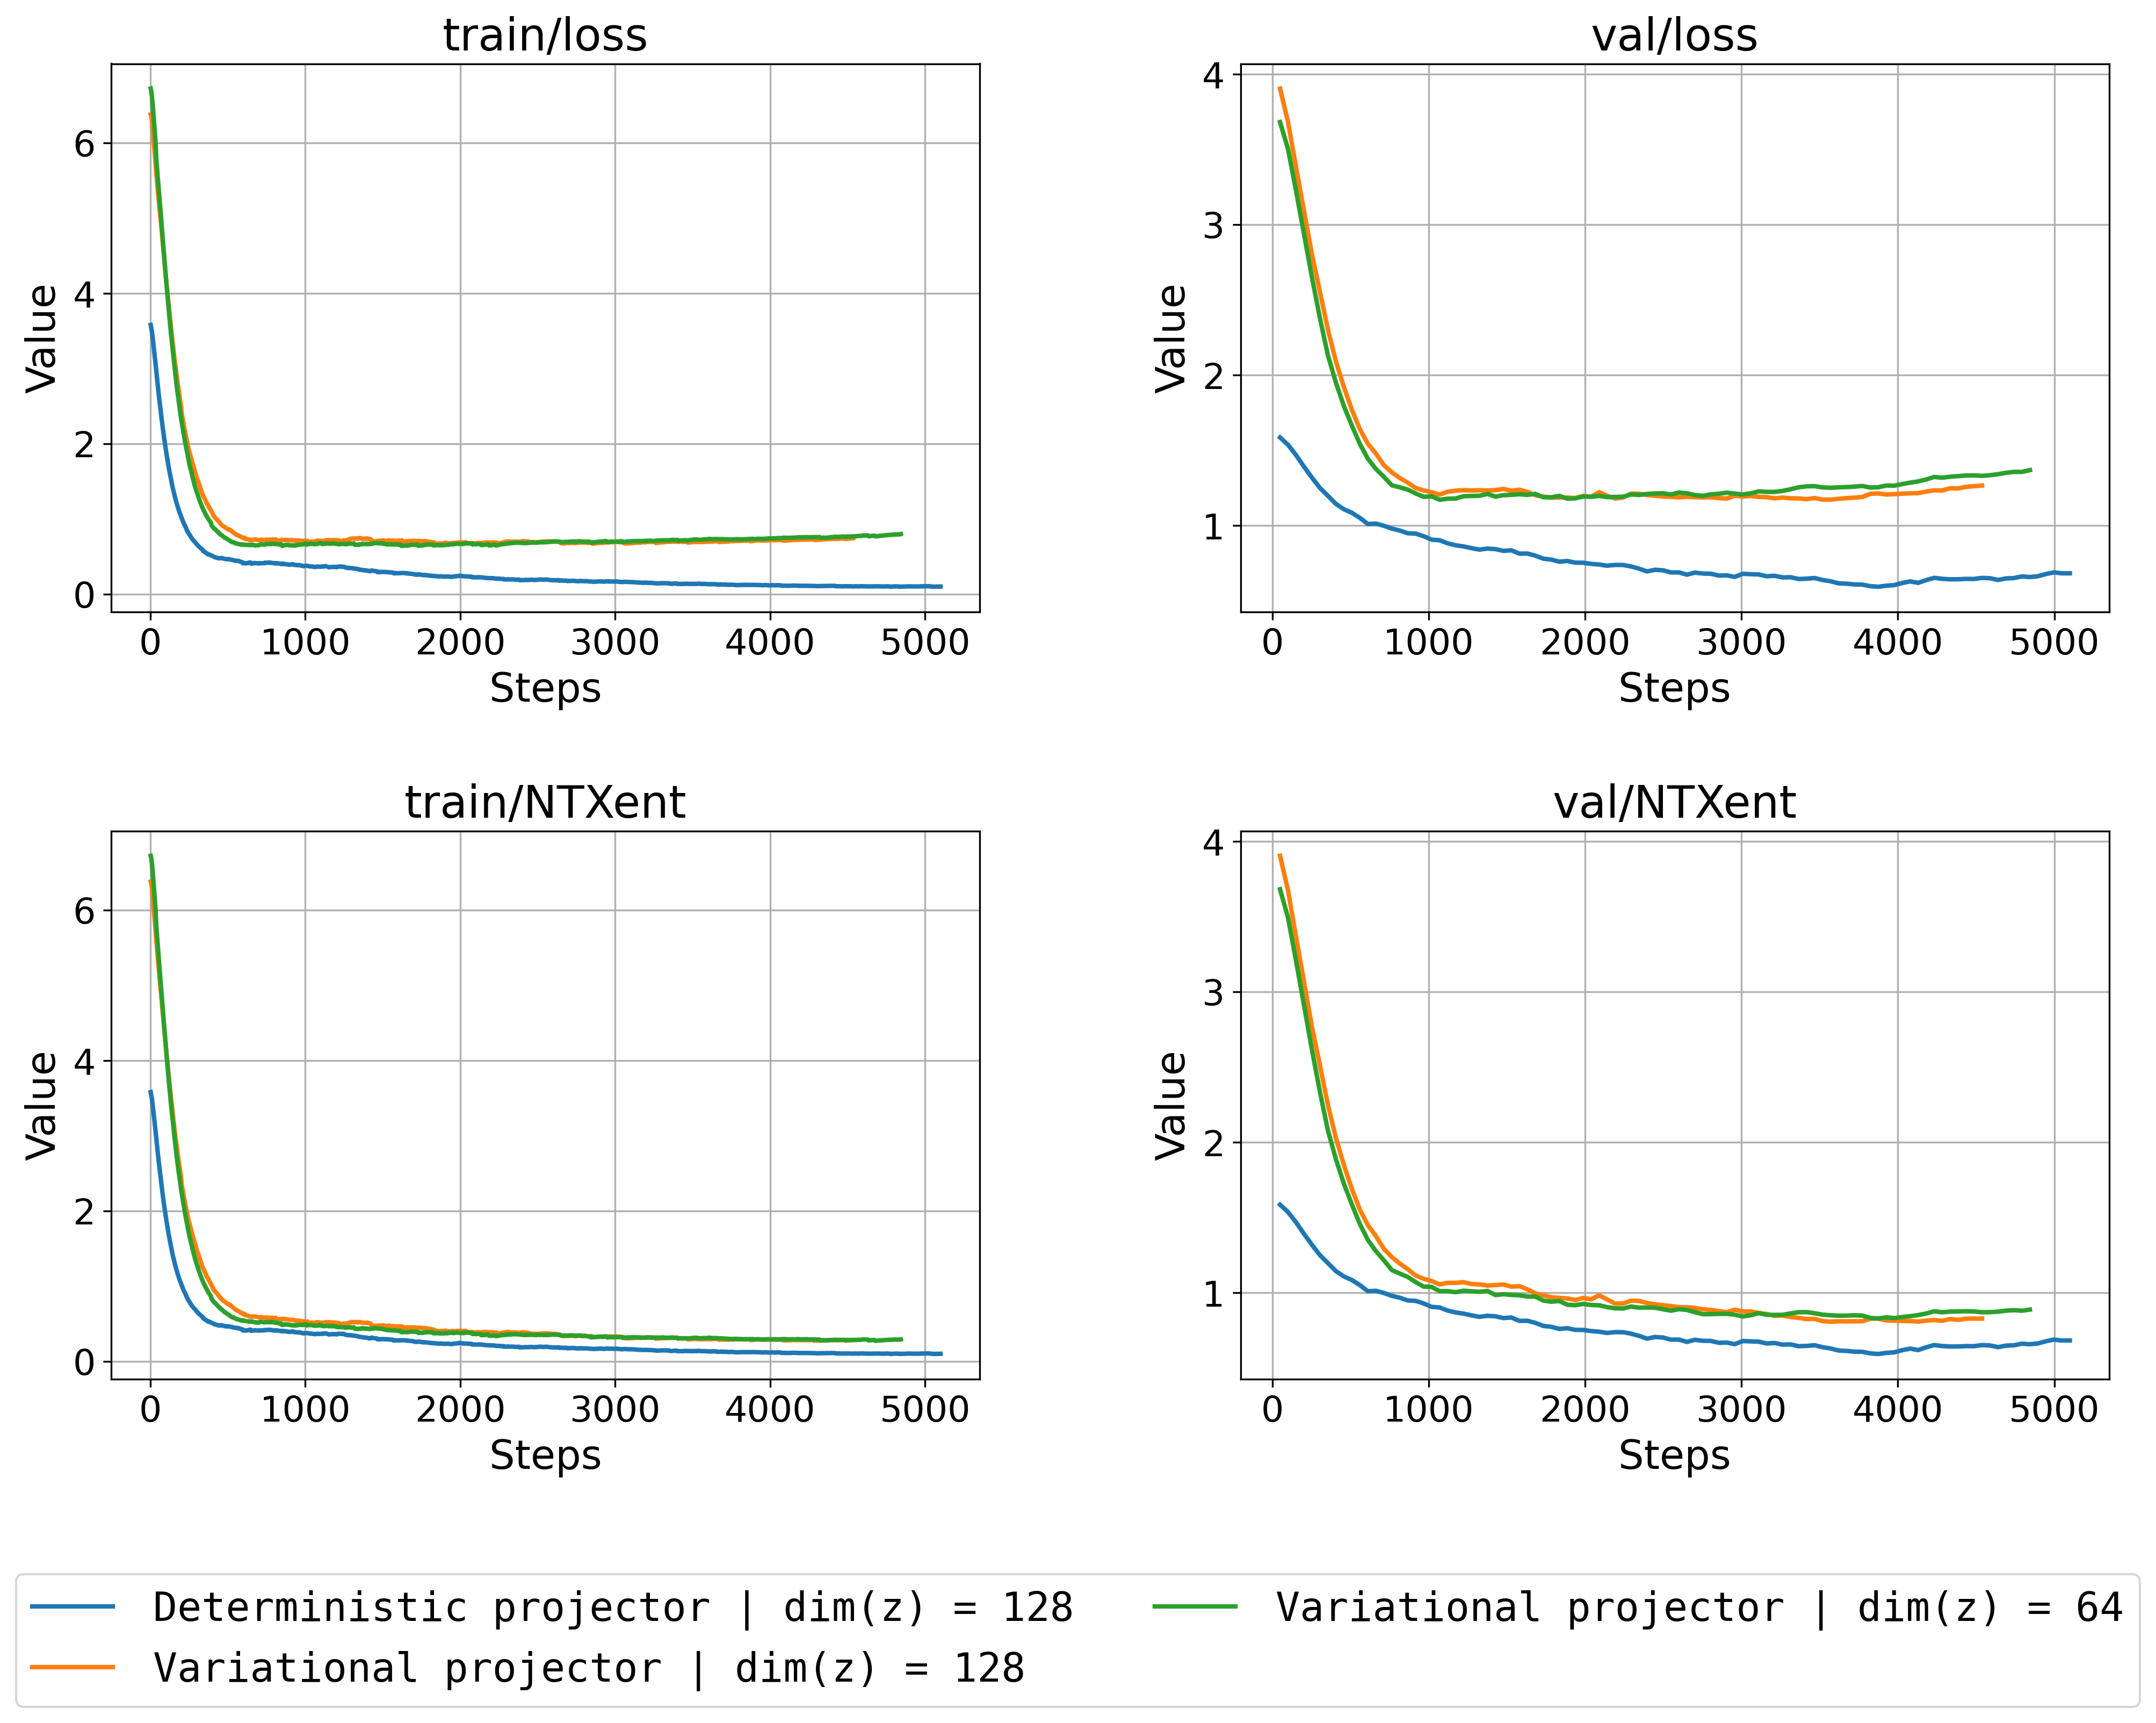

In [5]:
import pathlib
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

keys = ["train/loss_step", "val/loss", "train/NTXent_step", "val/NTXent"]
alpha_per_split = {
    "train": 0.05,
    "val":   0.20,
}

def load_series_tbparse(logdir, tag):
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    scalars = ea.Scalars(tag)
    steps = [s.step  for s in scalars]
    vals  = [s.value for s in scalars]
    return steps, vals

def smooth(y, alpha):
    if not y:
        return []
    s = [y[0]]
    for yi in y[1:]:
        s.append(alpha * yi + (1 - alpha) * s[-1])
    return s

folders = [
    str(x) for x in pathlib.Path('tb_logs/disent_rep').iterdir()
    if x.is_dir() and not x.name.startswith("_")
]
folder_labels = [pathlib.Path(f).name for f in folders]

plt.rcParams.update({
    "figure.figsize":   (16, 12),
    "figure.dpi":       300,
    "font.size":        18,
    "axes.titlesize":   20,
    "axes.labelsize":   20,
    "legend.fontsize":  18,
    "xtick.labelsize":  16,
    "ytick.labelsize":  16,
})

fig, axs = plt.subplots(2, 2,
                       figsize=(16, 12),
                       dpi=300,
                       gridspec_kw={"wspace": 0.30, "hspace": 0.4})

for ax, key in zip(axs.flat, keys):
    split, metric = key.split("/", 1)
    alpha = alpha_per_split.get(split, 0.1)

    for folder, lbl in zip(folders, folder_labels):
        x, y   = load_series_tbparse(folder, key)
        y_smth = smooth(y, alpha)
        ax.plot(x, y_smth, label=lbl, linewidth=2)

    metric_name = metric.split("_", 1)[0]
    ax.set_title(f"{split}/{metric_name}", fontsize=20)
    ax.set_xlabel("Steps", fontsize=18)
    ax.set_ylabel("Value", fontsize=18)
    ax.grid(True)

fig.subplots_adjust(bottom=0.2)

handles, leg_labels = axs.flat[0].get_legend_handles_labels()
fig.legend(
    handles, leg_labels,
    ncol=2,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.02),
    frameon=True,
    prop={"family": "monospace", "size": 18},
    columnspacing=2.0,
    handletextpad=1.0,
)

fig.savefig(
    "visuals/training_comparison_grid.pdf",
    format="pdf",
    bbox_inches="tight",
    pad_inches=0.2
)
plt.show()